In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb

keras = tf.keras

print("Tensorflow Version: " + tf.VERSION)

Tensorflow Version: 1.13.1


# IMDB Dataset 
https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [29]:
# imdb data

NUM_WORDS=1500 # only use top 1000 words
INDEX_FROM=0   # word index offset

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)

# word index
word_index = imdb.get_word_index()
word_to_id = {k: (v + INDEX_FROM) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

word_index_inv = {v: k for k, v in word_index.items()}

def encoded_vector2sentence(vec, word_index_inv = word_index_inv):
    sentence = map(lambda i: word_index_inv[i], vec)
    return " ".join(sentence)

def pad_input(vec, maxlen):
    return keras.preprocessing.sequence.pad_sequences(vec, maxlen=maxlen, padding='post')

def sentence2encoded_vec(sentence):
    sentence_arr = sentence.split(" ")
    return list(map(lambda word: word_index[word.lower()], sentence_arr))

In [30]:
# raw data representation
print(x_train[0], y_train[0])

[1, 11, 19, 13, 40, 527, 970, 2, 1382, 62, 455, 2, 63, 2, 1, 170, 33, 253, 2, 22, 97, 40, 835, 109, 47, 667, 2, 6, 32, 477, 281, 2, 147, 1, 169, 109, 164, 2, 333, 382, 36, 1, 169, 2, 1108, 14, 543, 35, 10, 444, 1, 189, 47, 13, 3, 144, 2, 16, 11, 19, 1, 2, 2, 466, 1, 19, 68, 84, 9, 13, 40, 527, 35, 73, 12, 10, 1244, 1, 19, 14, 512, 14, 9, 13, 623, 15, 2, 2, 59, 383, 9, 5, 313, 5, 103, 2, 1, 2, 2, 13, 477, 63, 2, 30, 1, 127, 9, 13, 35, 616, 2, 22, 121, 48, 33, 132, 45, 22, 1412, 30, 3, 19, 9, 212, 25, 74, 49, 2, 11, 404, 13, 79, 2, 5, 1, 104, 114, 2, 12, 253, 1, 2, 4, 2, 2, 720, 33, 68, 40, 527, 473, 23, 397, 314, 43, 4, 1, 2, 1026, 10, 101, 85, 1, 378, 12, 294, 95, 29, 2, 53, 23, 138, 3, 191, 2, 15, 1, 223, 19, 18, 131, 473, 23, 477, 2, 141, 27, 2, 15, 48, 33, 25, 221, 89, 22, 101, 1, 223, 62, 13, 35, 1331, 85, 9, 13, 280, 2, 13, 2, 110, 100, 29, 12, 13, 2, 16, 175, 29] 1


In [31]:
# parsed sentence
print(encoded_vector2sentence(x_train[0]))

<START> this film was just brilliant casting <UNK> scenery story direction <UNK> really <UNK> <START> part they played <UNK> you could just imagine being there robert <UNK> is an amazing actor <UNK> now <START> same being director <UNK> father came from <START> same <UNK> island as myself so i loved <START> fact there was a real <UNK> with this film <START> <UNK> <UNK> throughout <START> film were great it was just brilliant so much that i bought <START> film as soon as it was released for <UNK> <UNK> would recommend it to everyone to watch <UNK> <START> <UNK> <UNK> was amazing really <UNK> at <START> end it was so sad <UNK> you know what they say if you cry at a film it must have been good <UNK> this definitely was also <UNK> to <START> two little <UNK> that played <START> <UNK> of <UNK> <UNK> paul they were just brilliant children are often left out of <START> <UNK> list i think because <START> stars that play them all <UNK> up are such a big <UNK> for <START> whole film but these ch

In [32]:
# Max Input Length
max_length = max(map(lambda vec: len(vec), x_train + x_test))

# pad input vectors
x_train_padded = pad_input(x_train, max_length)
x_test_padded = pad_input(x_test, max_length)
x_train_padded[0]

array([ 1, 11, 19, ...,  0,  0,  0])

In [33]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
model = keras.Sequential([
    keras.layers.Embedding(len(word_index), 3, input_length=max_length),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2697, 3)           265761    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8091)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               1618400   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 1,884,362
Trainable params: 1,884,362
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir='./logs', 
    histogram_freq=0,
    write_graph=True, 
    write_images=True) 

model.fit(x_train_padded, y_train, validation_split=0.3, epochs=10, callbacks=[tb_callback])
loss, accuracy = model.evaluate(x_train_padded, y_train)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % loss)

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 4s 234us/sample - loss: 0.5406 - acc: 0.7023 - val_loss: 0.3725 - val_acc: 0.8315
Epoch 2/10
17500/17500 [==============================] - 4s 216us/sample - loss: 0.3159 - acc: 0.8680 - val_loss: 0.3250 - val_acc: 0.8628
Epoch 3/10
17500/17500 [==============================] - 4s 219us/sample - loss: 0.2661 - acc: 0.8911 - val_loss: 0.3255 - val_acc: 0.8641
Epoch 4/10
17500/17500 [==============================] - 4s 217us/sample - loss: 0.2262 - acc: 0.9078 - val_loss: 0.3330 - val_acc: 0.8647
Epoch 5/10
17500/17500 [==============================] - 4s 217us/sample - loss: 0.1847 - acc: 0.9300 - val_loss: 0.3785 - val_acc: 0.8581
Epoch 6/10
17500/17500 [==============================] - 4s 221us/sample - loss: 0.1327 - acc: 0.9509 - val_loss: 0.4343 - val_acc: 0.8532
Epoch 7/10
17500/17500 [==============================] - 4s 218us/sample - loss: 0.0869 - acc: 0.9713 - val_lo

In [35]:
def test_model(x, y):
    test_result = np.round(model.predict(x))
    test_errors = np.squeeze(test_result) != y
    correct_percentage = np.sum(test_errors) / len(y)
    print("%i / %i (%.2f%%) are correct" % (len(y) - np.sum(test_errors), len(y), 100 * (1 - correct_percentage)))

In [36]:
test_model(x_test_padded, y_test)

21103 / 25000 (84.41%) are correct


In [49]:
sample_vecs = pad_input([sentence2encoded_vec("this was a very bad movie")], max_length)
test_model(sample_vecs, [[0]])

1 / 1 (100.00%) are correct


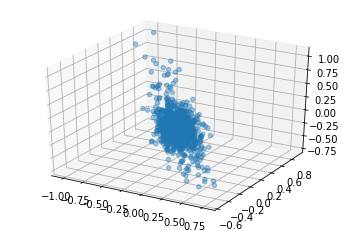

In [39]:
embeding_weights = model.layers[0].get_weights()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.transpose(embeding_weights)[0][:1000]
y = np.transpose(embeding_weights)[1][:1000]
z = np.transpose(embeding_weights)[2][:1000]
ax.scatter(x, y, z, alpha=0.4)